# Bootstrap analysis for training data
This notebook is to guide through the process of doing bootstrap analysis for the amount of training data i.e. duration of unique stimuli available for fitting the model.

Here is step by step process;

**1. Using different proportions of data to fit the model** \
Use /scripts/bootstrap_estimage.py to fit using different proportions of data. Specifically, this script allows using from 10% to 100% of training data to fit the model and saves the resulting correlations. For each proportion of data used, a separate file will be saved to the results directory, and we would want to repeat this mechanim to fit using varying amounts of data multiple times (hence the name bootstap) so it is critical to use naming convention for the files saved with correlation results. "bootstrap_training_data.sh" script implements an example of submitting jobs for all levels of data subsets (10 to 100%) to compute the results.

```
./bootstrap_training_data.sh "-d ucdavis -i itr"
```
This will submit 10 jobs and results will be saved with identifiers; 
- $[ucdavis]\_timit\_trf\_lags300\_bw50\_boot\_[itr]\_10$
- $[ucdavis]\_timit\_trf\_lags300\_bw50\_boot\_[itr]\_20$
- $[ucdavis]\_timit\_trf\_lags300\_bw50\_boot\_[itr]\_30$
- $[ucdavis]\_timit\_trf\_lags300\_bw50\_boot\_[itr]\_40$
- $[ucdavis]\_timit\_trf\_lags300\_bw50\_boot\_[itr]\_50$
- $[ucdavis]\_timit\_trf\_lags300\_bw50\_boot\_[itr]\_60$
- $[ucdavis]\_timit\_trf\_lags300\_bw50\_boot\_[itr]\_70$
- $[ucdavis]\_timit\_trf\_lags300\_bw50\_boot\_[itr]\_80$
- $[ucdavis]\_timit\_trf\_lags300\_bw50\_boot\_[itr]\_90$
- $[ucdavis]\_timit\_trf\_lags300\_bw50\_boot\_[itr]\_100$

Do this 80 times, with specifying itr=1...80 to get 80 samples at each proportion of data.

**2. Compute normalizers for the sessions being analyzed** \
Make sure the normalizers are computed and saved to the memory for all the sessions (or at least the ones that are included in the bootstrap analysis). Sessions to be included in the bootsrap analysis can be specified within the script `bootstrap_estimate2.py`. In case there are large number of sessions being analysed, running this code as a batch script might be a better option. Nevertheless the code is a couple of lines of code as given below.

In [ ]:
from auditory_cortex.neural_data.normalizer_calculator import NormalizerCalculator
bin_width = 50
mVocs = False
session_ids = [0,1,2]
for sess_id in session_ids:
	normalizer = NormalizerCalculator('ucdavis', sess_id)

	dist = normalizer.get_normalizer_for_session_random_pairs(
		bin_width=bin_width, mVocs=mVocs
	)

**3. Compute null distribution for the dataset analyzed** \
Make sure the null distribution is computed and saved to the memory. Normally null distribution using random poisson sequences is used so one null distributions is computed for the entire stimulus set. It actually depends on the length of the long sequences (i.e. duration of repeated stimuli).

In [ ]:
from auditory_cortex.neural_data.normalizer_calculator import NormalizerCalculator
# any session id will work, as the stimuli are the same for all sessions in a dataset
sess_id = 0	
bin_width = 50
mVocs = False
num_itr=100000
normalizer = NormalizerCalculator('ucdavis', sess_id)
null_dist_ucdavis = normalizer.get_normalizer_null_dist_using_poisson(
	bin_width=bin_width, num_itr=num_itr, mVocs=mVocs)

**4. Combining results Adding normalizers to all the results saved in the first step** \
After we have saved all the results of the first step, and computed normalizer as well as null distribution, we can start analyzing the results of bootsrap analysis. The first step is to combine the results for different proportions of data into a single file, for each iteration, so that we have only one file for one iteration. Next we incorporate the normalizer into the saved results. For 80 iterations of bootsrap, we will have 80*10=800 files saved to the memory. After combining they would reduce to 80 and we'll then update the normalizer for each of these files in a loop. So I have written the helper functions to help with that. For now, I am defining them within this notebook, I might move them to a separate helper class.

In [1]:
import numpy as np
from auditory_cortex.analyses.correlations_analyzer import Correlations

def display_sessions_done(
	model_name, identifier, verbose=False, num_sessions=41, N_sents=499):
	"""Display the number of sessions done for all bin widths
	"""
	if verbose:
		print(f"For '{model_name}', '{identifier}'")
	try:
		corr_obj = Correlations(model_name+'_'+identifier)
	except:
		print(f"Model '{model_name}' with identifier '{identifier}' not found")
		return [model_name+'_'+identifier]
	bin_widths = np.sort(corr_obj.data['bin_width'].unique())
	return_list = []
	for bin_width in bin_widths:
		data = corr_obj.get_selected_data(bin_width=bin_width, N_sents=N_sents)
		if verbose:
			print(f"For bin_width: {bin_width:03} ms, sessions done: {len(data['session'].unique())}")
		if len(data['session'].unique()) != num_sessions:
			return_list.append(model_name+'_'+identifier+f'{bin_width}')
		else:
			return_list.append(None)
	return return_list

def check_bootstrap_results(
	identifier, num_sessions, model_names=None, bin_width=50,
	verbose=False, N_sents=None
	):
	"""Check if the bootstrap results are done for all sessions
	"""
	models_not_done = []
	if model_names is None:
		model_names = num_layers.keys()
	if N_sents is None:
		N_sents = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
	for model_name in model_names:
		# not_done = display_sessions_done(
		# 	model_name, identifier, verbose=verbose, num_sessions=num_sessions)
		# models_not_done.extend(not_done)
		for N in N_sents:
			not_done = display_sessions_done(
				model_name, f'{identifier}_{N}',
				verbose=verbose, num_sessions=num_sessions, N_sents=N
				)
			models_not_done.extend(not_done)

	# remove None entries..
	while None in models_not_done:
		models_not_done.remove(None)
	
	if len(models_not_done) ==0:
		print(f"All models done..for {identifier}")
	else:
		print(f"Models with incomplete resutls:")
		for iden in models_not_done:
			print(iden)

def combine_bootstrap_results(
	identifier, model_names, N_sents=None
	):
	"""Combines results for the list of models provided"""

	if N_sents is None:
		N_sents = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
	for model_name in model_names:
		ids = [f'{identifier}_{N}' for N in N_sents]
		Correlations.combine_and_ready(
			model_name,
			ids, 0,
			output_identifier=identifier
			)

In [3]:
model_names = [
	'whisper_base',
]
dataset_name = 'ucdavis'
stim = 'timit'
bin_width = 50
num_sessions = 3

identifiers = [f'{dataset_name}_{stim}_trf_lags300_bw{bin_width}_boot_{i}' for i in range(1, 81)]
N_sents = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [12]:
for identifier in identifiers:
	check_bootstrap_results(
		identifier, num_sessions, model_names=model_names, bin_width=bin_width,
		verbose=True, N_sents=N_sents)


For 'whisper_base', 'ucdavis_timit_trf_lags300_bw50_boot_1_10'
For bin_width: 50.0 ms, sessions done: 3
For 'whisper_base', 'ucdavis_timit_trf_lags300_bw50_boot_1_20'
For bin_width: 50.0 ms, sessions done: 3
For 'whisper_base', 'ucdavis_timit_trf_lags300_bw50_boot_1_30'
For bin_width: 50.0 ms, sessions done: 3
For 'whisper_base', 'ucdavis_timit_trf_lags300_bw50_boot_1_40'
For bin_width: 50.0 ms, sessions done: 3
For 'whisper_base', 'ucdavis_timit_trf_lags300_bw50_boot_1_50'
For bin_width: 50.0 ms, sessions done: 3
For 'whisper_base', 'ucdavis_timit_trf_lags300_bw50_boot_1_60'
For bin_width: 50.0 ms, sessions done: 3
For 'whisper_base', 'ucdavis_timit_trf_lags300_bw50_boot_1_70'
For bin_width: 50.0 ms, sessions done: 3
For 'whisper_base', 'ucdavis_timit_trf_lags300_bw50_boot_1_80'
For bin_width: 50.0 ms, sessions done: 3
For 'whisper_base', 'ucdavis_timit_trf_lags300_bw50_boot_1_90'
For bin_width: 50.0 ms, sessions done: 3
For 'whisper_base', 'ucdavis_timit_trf_lags300_bw50_boot_1_100'


if the above test is passed, that means all the files have the results for the sessions specified in the script. Now we can combine files for each iteration.

In [17]:
for identifier in identifiers:
	combine_bootstrap_results(identifier, model_names=model_names, N_sents=N_sents)

Combining results...
Output saved at: 
 /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_base_ucdavis_timit_trf_lags300_bw50_boot_1_corr_results.csv
reading from /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_base_ucdavis_timit_trf_lags300_bw50_boot_1_corr_results.csv
Writing back...!
Combining results...
Output saved at: 
 /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_base_ucdavis_timit_trf_lags300_bw50_boot_2_corr_results.csv
reading from /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_base_ucdavis_timit_trf_lags300_bw50_boot_2_corr_results.csv
Writing back...!
Combining results...
Output saved at: 
 /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_base_ucdavis_timit_trf_lags300_bw50_boot_3_corr_results.csv
reading from /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_base_ucdavis_timit_tr

In [5]:
model_name = 'whisper_base'
mVocs = False
# identifiers = [f'{dataset_name}_{stim}_trf_lags300_bw{bin_width}_boot_{i}' for i in range(1, 81)]
for identifier in identifiers:
	corr_obj = Correlations(model_name+'_'+identifier)
	corr_obj.set_normalizers_using_bootsrap(mVocs=mVocs)
	print(f"Done for identifier: {identifier}")

Columns: 'normalizer', 'test_cc_raw', 'normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_base_ucdavis_timit_trf_lags300_bw50_boot_1_corr_results.csv
Done for identifier: ucdavis_timit_trf_lags300_bw50_boot_1
Columns: 'normalizer', 'test_cc_raw', 'normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_base_ucdavis_timit_trf_lags300_bw50_boot_2_corr_results.csv
Done for identifier: ucdavis_timit_trf_lags300_bw50_boot_2
Columns: 'normalizer', 'test_cc_raw', 'normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_base_ucdavis_timit_trf_lags300_bw50_boot_3_corr_results.csv
Done for identifier: ucdavis_timit_trf_lags300_bw50_boot_

**5. Computing medians of distributions and saving to disk**

In [1]:
from auditory_cortex.analyses.correlations_analyzer import Correlations
from auditory_cortex.io_utils import io
def get_medians_for_single_itr(corr_obj, bin_width=50, mVocs=False):

	threshold = corr_obj.get_normalizer_threshold(bin_width=bin_width, mVocs=mVocs)
	select_data = corr_obj.get_selected_data(threshold=threshold, bin_width=bin_width, mVocs=mVocs)
	medians = {}
	N_sents = select_data['N_sents'].unique()
	for N in N_sents:
		medians[N] = select_data[select_data['N_sents'] == N]['normalized_test_cc'].median()
	return medians

def get_median_dist_for_all_itr(identifiers, model_name, bin_width=50):

	median_dists = {}
	for identifier in identifiers:
		corr_obj = Correlations(model_name+'_'+identifier)
		medians = get_medians_for_single_itr(corr_obj, bin_width=bin_width, mVocs=False)
		for N, median in medians.items():
			if N not in median_dists:
				median_dists[N] = []
			median_dists[N].append(median)

	return median_dists

def get_bootstrap_medians(identifiers, model_name, dataset_name='ucsf', force_redo=False, test=False):
	if not force_redo:
		median_dist = io.read_bootstrap_median_dist(
			model_name, bin_width=50, mVocs=False, verbose=True, test=test,
			dataset_name=dataset_name
			)
		if median_dist is not None:
			return median_dist
	median_dist = get_median_dist_for_all_itr(identifiers, model_name=model_name, bin_width=50)
	io.write_bootstrap_median_dist(
		median_dist, model_name, bin_width=50, mVocs=False, test=test,
		dataset_name=dataset_name
		)
	return median_dist

In [5]:
dist = get_bootstrap_medians(identifiers, 'whisper_base', dataset_name='ucdavis', test=False)

Reading from file: /scratch/gilbreth/ahmedb/cache/bootstrap/whisper_base/ucdavis/whisper_base_bootstrap_medians_50ms.pkl


**6. Plotting...**

Reading from file: /scratch/gilbreth/ahmedb/cache/bootstrap/whisper_base/ucdavis/whisper_base_bootstrap_medians_50ms.pkl


Text(0.5, 1.0, "Bootstrap estimates for 'ucdavis' dataset")

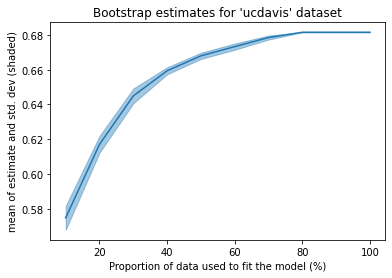

In [13]:
import numpy as np
import matplotlib.pyplot as plt

model_name = 'whisper_base'
dataset_name = 'ucdavis'
stim = 'timit'
test=False
bin_width = 50
identifiers = [f'{dataset_name}_{stim}_trf_lags300_bw{bin_width}_boot_{i}' for i in range(1, 81)]
median_dists = get_bootstrap_medians(identifiers, model_name, dataset_name=dataset_name, test=test)
proportion_of_data = list(median_dists.keys())
means = [np.mean(median_dists[N]) for N in proportion_of_data]
std_errors = [np.std(median_dists[N]) for N in proportion_of_data]

std_errors = np.array(std_errors)
plt.plot(proportion_of_data, means, label='Mean', color='tab:blue')

# Plot the standard error as shaded region
plt.fill_between(proportion_of_data, means - std_errors/2, means + std_errors/2, 
				 color='tab:blue', alpha=0.4, label='Standard Error')
plt.xlabel('Proportion of data used to fit the model (%)')
plt.ylabel("mean of estimate and std. dev (shaded)")
plt.title(f"Bootstrap estimates for '{dataset_name}' dataset")